In [1]:
from Utilities import *
from PuzzlePiece import *

In [2]:
# gather all the pieces
pieces = {}
for p in ['C','N','NE','E','SE','S','SW','W','NW']:
    pieces[p] = Piece('representations/' + p + '_border_ordered.csv')

In [3]:
# get the first piece
query = pieces.pop('C')

In [ ]:
# find the closest match in the other pieces
mx_score = 0
mx_piece = ''

for p in pieces:
    # need an alignment object to store the results from these 
    target_rev = { i:pieces[p].sampled_pts[i]
                   for i in list(pieces[p].sampled_pts.keys())[::-1] }
    SuffTable, mx, mx_Q, mx_T, length = \
        AlignPieces_Euclid(query.sampled_pts, target_rev, window = 10)
    
    sims = []
    for i in range(1,len(SuffTable)):
        for j in range(1,len(SuffTable[i])):
            sims.append(SuffTable[i][j])

    sims.sort()
    cutoff = sims[int(len(sims)*.1)]
    
    # could build the dynamic programming table here
    SuffTable, mx, mx_Q, mx_T, length = \
        AlignPieces_Euclid(query.sampled_pts, target_rev,
                           mode = 'SW align', window = 10, cutoff = cutoff,
                           distr_score = True, avg = avg(sims), sd = sd(sims))
    
    print(p, mx, mx_Q, mx_T, length, mx/length)
    if mx > mx_score:
        mx_score = mx
        mx_piece = p
        
print('Best: ', mx_piece, mx_score, length)

In [4]:
# TODO: access the alignment object instead of reacalculating
mx_piece_rev = { i:pieces[mx_piece].sampled_pts[i]
                    for i in list(pieces[mx_piece].sampled_pts.keys())[::-1] }
SuffTable, mx, mx_q, mx_t, length = \
        AlignPieces_Euclid(query.sampled_pts, mx_piece_rev, window = 10)

sims = []
for i in range(1,len(SuffTable)):
    for j in range(1,len(SuffTable[i])):
        sims.append(SuffTable[i][j])

sims.sort()
cutoff = sims[int(len(sims)*.1)]
    
SuffTable, mx, mx_q, mx_t, length = \
        AlignPieces_Euclid(query.sampled_pts, mx_piece_rev,
                           mode = 'SW align', window = 10, cutoff = cutoff,
                           distr_score = True, avg = avg(sims), sd = sd(sims))

print(mx_piece, mx, mx_q, mx_t, length, mx/length)
#target = pieces.pop(mx_piece)
target = pieces[mx_piece]

E 169.28319139950804 188 196 57 2.969880550868562


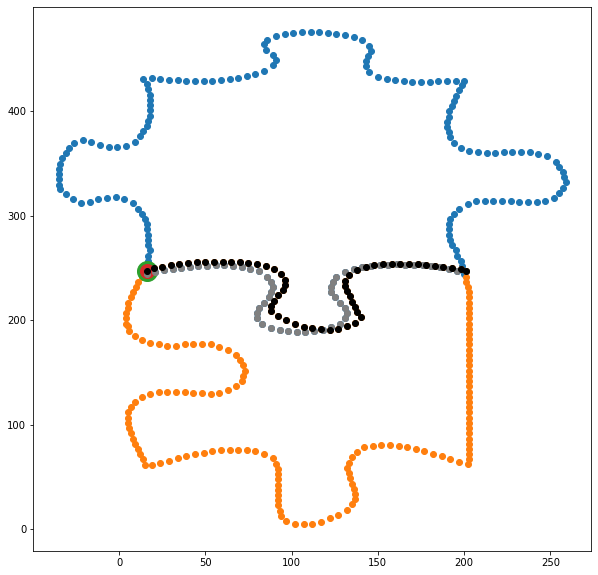

In [5]:
#find the best matched point - this is the end of the best match window
Q_pt = query.sampled_pts[list(query.sampled_pts.keys())[mx_q-1]]
T_pt = target.sampled_pts[list(target.sampled_pts.keys())[::-1][mx_t-1]] 

# find x,y shift to align pieces
Q_xshift = Q_pt['x'] - T_pt['x']
Q_yshift = Q_pt['y'] - T_pt['y'] 

plt.figure(figsize = [10,10])
plt.scatter( [query.sampled_pts[k]['x'] - Q_xshift for k,v in query.sampled_pts.items() ],
             [query.sampled_pts[k]['y'] - Q_yshift for k,v in query.sampled_pts.items() ])
plt.scatter( [target.sampled_pts[k]['x'] for k,v in target.sampled_pts.items() ],
             [target.sampled_pts[k]['y'] for k,v in target.sampled_pts.items() ])

plt.plot( [Q_pt['x'] - Q_xshift, T_pt['x']],
          [Q_pt['y'] - Q_yshift, T_pt['y']],
        linewidth = 3)

# show best matched points - second will overplot first due to alignment
plt.scatter( Q_pt['x'] - Q_xshift, Q_pt['y'] - Q_yshift, s=400)
plt.scatter( T_pt['x'], T_pt['y'], s=196 ) 

# show similarity window
# the black and white points repsent the points in the positive scoring diagonal
# of the suffix table starting at the maximum scoring point
# these points are the best locally aligned points
Q_window = [query.sampled_pts[p] for p in list(query.sampled_pts.keys())[ max((mx_q-length),0):(mx_q)] ]
plt.scatter( [p['x'] - Q_xshift for p in Q_window],
             [p['y'] - Q_yshift for p in Q_window], c = 'grey' )
T_window = [target.sampled_pts[p] for p in list(target.sampled_pts.keys())[::-1][(mx_t-length):(mx_t)] ]
plt.scatter( [p['x'] for p in T_window],
             [p['y'] for p in T_window], c = 'black' )